In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False

env_1_sale_args['num_products'] = 10
num_products = env_1_sale_args['num_products']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

env_1_sale_args['number_of_flips'] = 5
env_1_sale_args['num_users'] = 5000
env_1_sale_args

{'num_products': 10,
 'num_users': 5000,
 'random_seed': 42,
 'prob_leave_bandit': 0.01,
 'prob_leave_organic': 0.01,
 'prob_bandit_to_organic': 0.05,
 'prob_organic_to_bandit': 0.25,
 'normalize_beta': False,
 'with_ps_all': False,
 'num_clusters': 2,
 'phi_var': 0.1,
 'K': 5,
 'sigma_omega_initial': 1,
 'sigma_omega': 0.1,
 'number_of_flips': 5,
 'sigma_mu_organic': 3,
 'change_omega_for_bandits': False,
 'kappa': 0.2,
 'sigma_Lambda': 1,
 'psale_scale': 0.15,
 'delta_for_clicks': 0,
 'delta_for_views': 0,
 'sig_coef': 1}

In [3]:
num_users = 10000
num_AB_users = 5000

In [4]:
# Random policy as logging policy
try :
    data_random = pkl.load(open(str('data\data'+str(num_users)+'rand.pkl'),'rb'))
    data = data_random.copy()
except :
    data_random = deepcopy(env).generate_logs(num_users)
    data = data_random.copy()
    pkl.dump(data,open(str('data\data'+str(num_users)+'rand.pkl'),'wb'))

## Reward shaping

#### (1) Clicks : 
reward = click

In [5]:
from recogym.agents.sale_agent import ClickRewardProvider

Click_rewards = ClickRewardProvider()

#### (2) MDP (non-product-specific)
Attribute the reward of the MDP

In [6]:
from recogym.agents.sale_agent import MDPRewardProvider

MDP_rewards = MDPRewardProvider()
MDP_rewards_all = MDPRewardProvider(clicks_only=False)
MDP_rewards_pureorganic = MDPRewardProvider(clicks_only=False, organic_only=True)

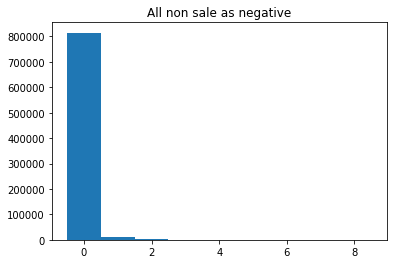

Share of sales that are taken into account in the trainset :  0.8359090637866221
Number of sales in the trainset : 14009.0


In [7]:
MDP_rewards_all.observe(data)
MDP_base_all = MDP_rewards_all.features()
# display(MDP_base_all)
# len(MDP_base_all)

trainset = MDP_base_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))
print("Number of sales in the trainset :",np.sum(trainset["y"]))

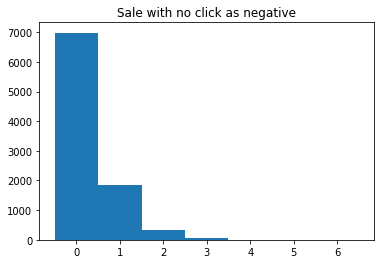

Share of sales that are taken into account in the trainset :  0.16283787815502118
Number of sales in the trainset : 2729.0


In [10]:
MDP_rewards.observe(data)
MDP_base = MDP_rewards.features()
# display(MDP_base)
# print(len(MDP_base))

trainset = MDP_base

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))
print("Number of sales in the trainset :",np.sum(trainset["y"]))

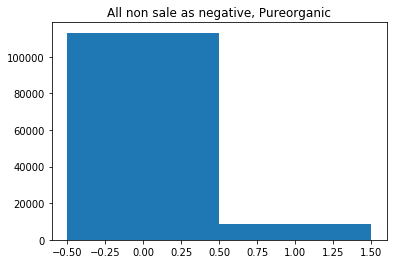

Share of sales that are taken into account in the trainset :  0.516080911748911
Number of sales in the trainset : 8649


In [11]:
MDP_rewards_pureorganic.observe(data)
MDP_base_pureorganic = MDP_rewards_pureorganic.features()

trainset = MDP_base_pureorganic

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative, Pureorganic")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))
print("Number of sales in the trainset :",np.sum(trainset["y"]))

#### (3) Non personnalized Short term (non product-specific)
Attribute a reward if any sale happened before the next clicked reco

In [12]:
from recogym.agents.sale_agent import NonPersoShortTermRewardProvider
nst_rewards = NonPersoShortTermRewardProvider()
nst_rewards_all = NonPersoShortTermRewardProvider(clicks_only=False)

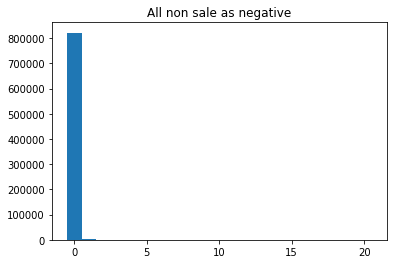

Share of sales that are taken into account in the trainset :  0.483919088251089


In [13]:
nst_rewards_all.observe(data)
nst_all = nst_rewards_all.features()

trainset = nst_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))

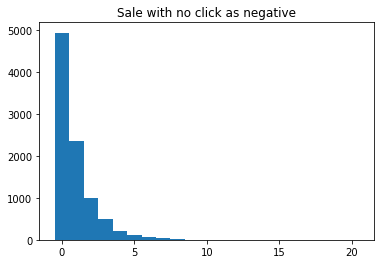

Share of sales that are taken into account in the trainset :  0.483919088251089


In [14]:
nst_rewards.observe(data)
nst = nst_rewards.features()

trainset = nst

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))

 #### (4) Short term reward provider (product-specific)
 Only attribute reward if the recommended product is sold before the next clicked recommendation 

In [15]:
from recogym.agents.sale_agent import ShortTermRewardProvider
st_rewards = ShortTermRewardProvider()
st_rewards_all = ShortTermRewardProvider(clicks_only=False)

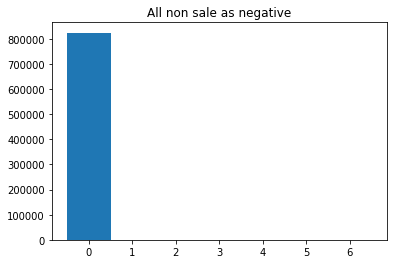

Share of sales that are taken into account in the trainset :  0.07452711975654872


In [16]:
st_rewards_all.observe(data)
st_all = st_rewards_all.features()

trainset = st_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))

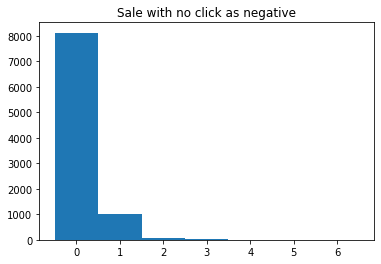

Share of sales that are taken into account in the trainset :  0.07452711975654872


In [17]:
st_rewards.observe(data)
st = st_rewards.features()
# st.to_csv("data/data_clicked.csv")

trainset = st

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))

#### (5) Cumulative reward provider (product-specific)
Attribute a reward if the product was sold later at one point during the user session

In case of several recommendations for the same product, attribute it to the last time it was recommended.
Thus, for each user : look at every sale, find the last time it was recommended (if any), and give reward

In [18]:
from recogym.agents.sale_agent import CumulativeRewardProvider
cum_rewards = CumulativeRewardProvider()
cum_rewards_all = CumulativeRewardProvider(clicks_only=False)

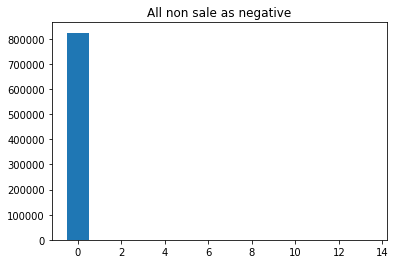

Share of sales that are taken into account in the trainset :  0.121307953935199


In [19]:
cum_rewards_all.observe(data)
cum_all = cum_rewards_all.features()

trainset = cum_all

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("All non sale as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum(data["z"]=="sale"))

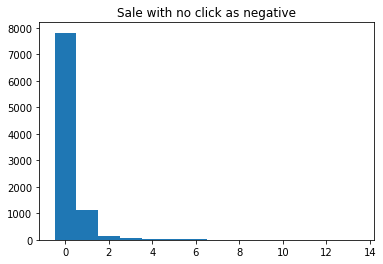

Share of sales that are taken into account in the trainset :  0.121307953935199


In [20]:
cum_rewards.observe(data)
cum = cum_rewards.features()
trainset = cum

plt.hist(trainset["y"], bins = np.array(sorted(list(trainset["y"].unique())+[max(trainset["y"])+1]))-0.5)
plt.title("Sale with no click as negative")
plt.show()
print("Share of sales that are taken into account in the trainset : ",
      np.sum(trainset["y"])/np.sum((data["z"]=="sale")))